In [6]:
#testing concatenation
%load_ext autoreload
%autoreload 2

In [7]:
import sys
sys.path.append('../../../src/')

import os
from typing import Dict
from os import PathLike
from pathlib import Path
import csv 
import glob

from aind_vr_foraging_analysis import utils
from aind_vr_foraging_analysis.utils import parse, processing, plotting_utils as plotting, AddExtraColumns
import datetime

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

import seaborn as sns
import pandas as pd
import numpy as np
import datetime

sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import ipywidgets as widgets
from IPython.display import display
from matplotlib.patches import Rectangle


colors = sns.color_palette()
odor_list_color = [colors[8], colors[0], colors[2], colors[4]]

pdf_path = r'/Volumes\scratch\vr-foraging\sessions'
base_path = r'/Volumes/scratch/vr-foraging/data/'
foraging_figures = r'/Users/nehal.ajmal/Documents/aindproject/results'

from scipy.optimize import curve_fit

In [8]:
# function to load session data
def load_session_data(session_path):
    try:
        data = parse.load_session_data(session_path)
        return data
    except Exception as e:
        print(f"Error loading session data from {session_path}: {e}")
        return None


In [6]:
session_path = r'/Volumes/scratch/vr-foraging/data/717716/717716_20240719T093806'
session_path = Path(session_path)
data = load_session_data(session_path)


{'harp_behavior': DataStreamSource from /Volumes/scratch/vr-foraging/data/717716/717716_20240719T093806/behavior/Behavior.harp,
 'harp_olfactometer': DataStreamSource from /Volumes/scratch/vr-foraging/data/717716/717716_20240719T093806/behavior/Olfactometer.harp,
 'harp_lickometer': DataStreamSource from /Volumes/scratch/vr-foraging/data/717716/717716_20240719T093806/behavior/Lickometer.harp,
 'harp_sniffsensor': DataStreamSource from /Volumes/scratch/vr-foraging/data/717716/717716_20240719T093806/behavior/SniffDetector.harp,
 'software_events': DataStreamSource from /Volumes/scratch/vr-foraging/data/717716/717716_20240719T093806/behavior/SoftwareEvents,
 'config': DataStreamSource from /Volumes/scratch/vr-foraging/data/717716/717716_20240719T093806/other/Config,
 'operation_control': DataStreamSource from /Volumes/scratch/vr-foraging/data/717716/717716_20240719T093806/behavior/OperationControl,
 'updater_events': DataStreamSource from /Volumes/scratch/vr-foraging/data/717716/717716_20

In [9]:
def process_session_data(data):
    try:
        # Parse data into a dataframe with the main features
        reward_sites, active_site, config = parse.parse_dataframe(data)
        
        return reward_sites, active_site, config
    except Exception as e:
        print(f"Error processing session data: {e}")
        return None


In [10]:
# example session_path
session_path = r'/Volumes/scratch/vr-foraging/data/717716/717716_20240719T093806'
session_path = Path(session_path)

# Load session data
data = load_session_data(session_path)

if data is not None:
    reward_sites, active_site, config = process_session_data(data)

else:
    print("Data loading failed. Cannot proceed with processing.")

In [11]:
#add extra columns
reward_sites = AddExtraColumns(reward_sites, active_site, run_on_init=True).reward_sites

In [ ]:
#make the plot_df
plot_df = active_site.reset_index()
plot_df['next_site'] = plot_df['Seconds'].shift(-1)
plot_df['time_spent'] = plot_df['next_site'] - plot_df['Seconds']
plot_df = plot_df[plot_df['label'] == 'RewardSite']
plot_df = plot_df[plot_df['time_spent'] < 15]  # remove outliers

plot_df['time_spent_adjusted'] = plot_df['time_spent']
plot_df.loc[plot_df['length'] > 20, 'time_spent_adjusted'] = plot_df['time_spent'] * (20 / plot_df['length'])
plot_df = plot_df.groupby(['active_patch', 'odor_label'], as_index=False)['time_spent_adjusted'].sum()


In [13]:
# helper function to save a plot as PNG
def save_plot_as_png(fig, save_path):
    fig.savefig(save_path, bbox_inches='tight')
    plt.close(fig)

In [ ]:
# function to save individual session plot
def save_session_plot(plot_df, mouse, session_date, session_time, save_folder):
    fig, ax = plt.subplots()
    hue_order = np.sort(plot_df['odor_label'].unique())
    ax = sns.scatterplot(data=plot_df, x='active_patch', y='time_spent_adjusted', hue='odor_label', hue_order=hue_order, ax=ax, palette=odor_list_color)
    ax.set_xlabel('Site #')
    ax.set_ylabel('Duration (s)')
    ax.set_title(f'{mouse} {session_date}')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2)

    # Display the plot interactively
    plt.show()

    #save plot using helper function
    plot_filename = f'{mouse}_{session_date}_{session_time}.png'
    plot_path = Path(save_folder) / plot_filename
    save_plot_as_png(fig, plot_path)
    
    return plot_path

plot_df = process_session_data(data)
save_session_plot(plot_df, '717716', '20240719', '093806', foraging_figures)

In [29]:
#load all session data for a mouse and save plots using save plot helper function
def process_mouse_sessions(mouse_id, save_folder):
    session_paths = glob.glob(f'/Volumes/scratch/vr-foraging/data/{mouse_id}/*')
    session_paths.sort(key=lambda x: (x[-15:-7], x[-6:-1]))
    
    all_data = []
    session_site_counts = []
    session_plot_paths = [] 
    
    for session_path in session_paths:
        plot_df, mouse, session_date, session_time = process_session_data(Path(session_path))
        
        if plot_df is None:
            continue
        
        session_site_counts.append(len(plot_df))
        plot_path = save_session_plot(plot_df, mouse, session_date, session_time, save_folder)
        session_plot_paths.append(plot_path)
        plot_df['session_id'] = f'{mouse}_{session_date}_{session_time}'
        
        all_data.append(plot_df)
    
    return all_data, session_site_counts, session_plot_paths

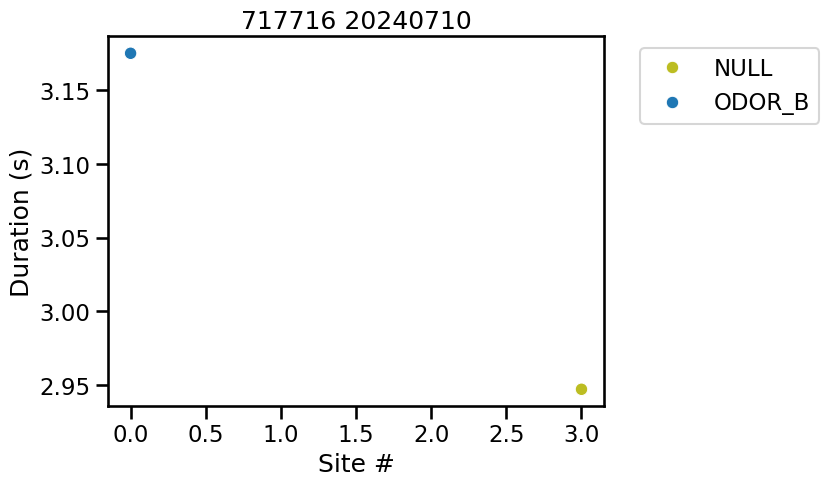

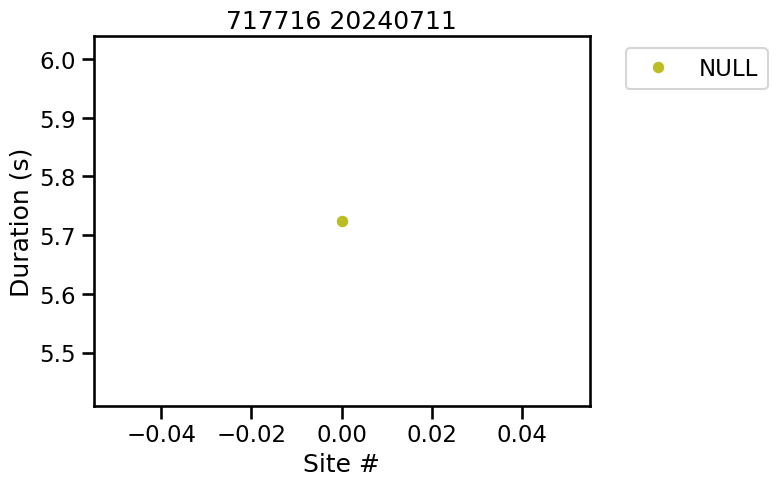

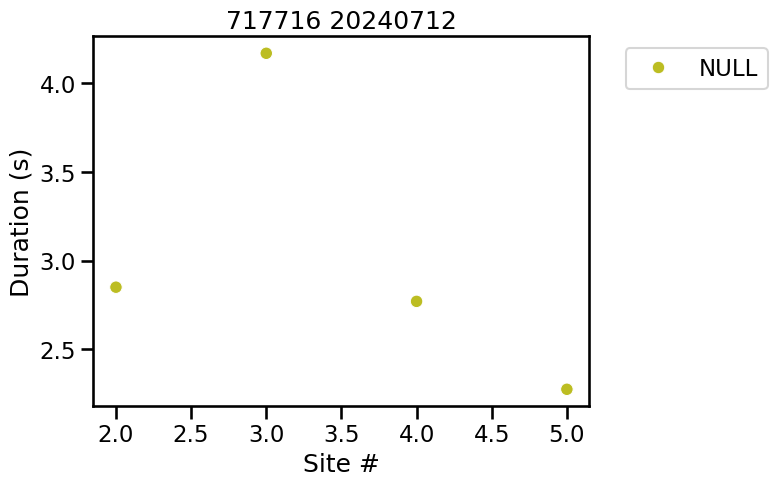

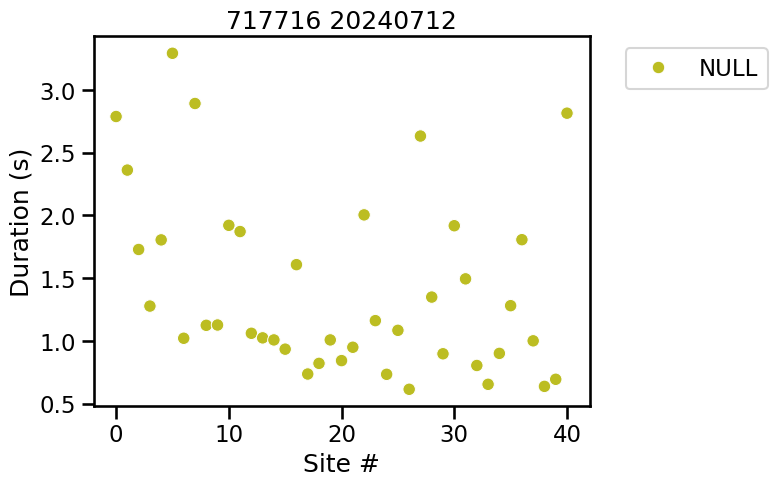

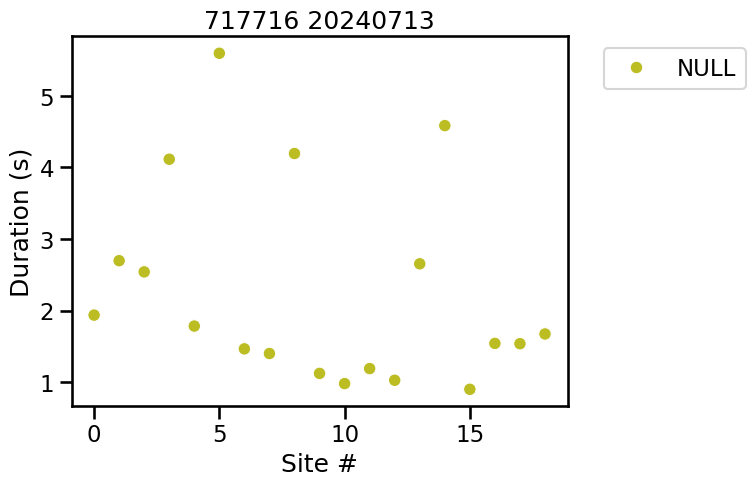

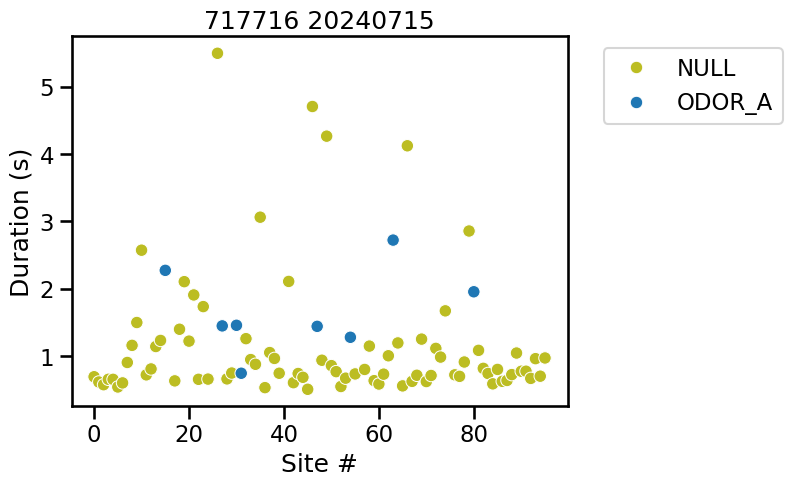

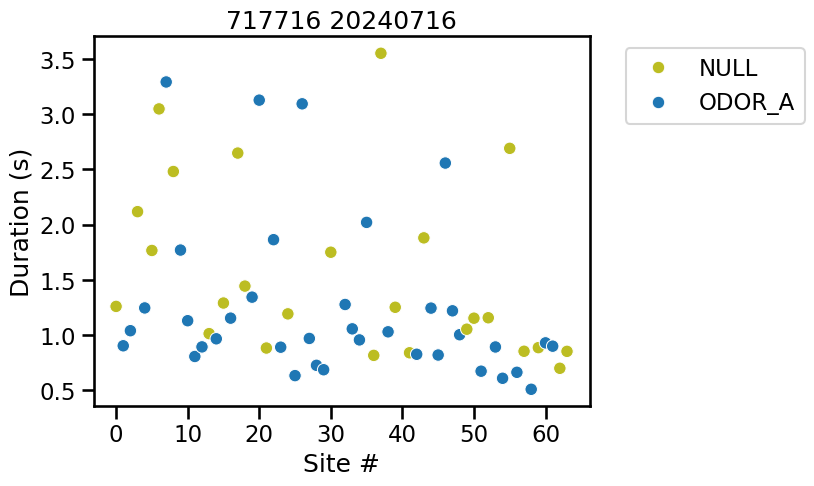

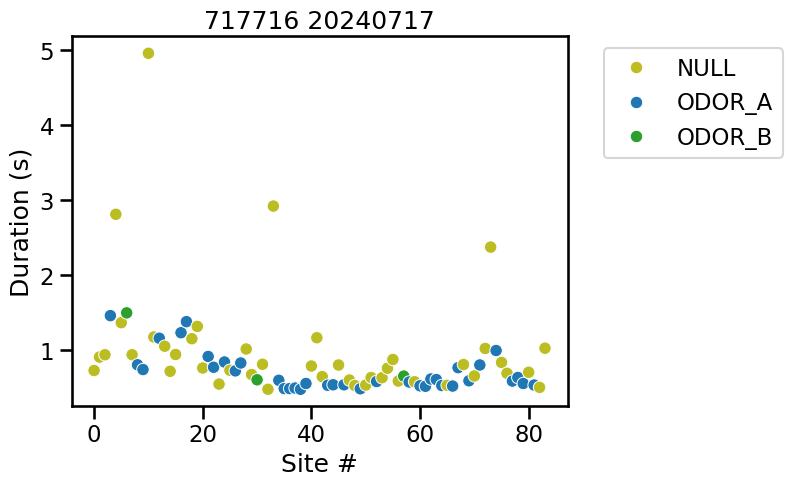

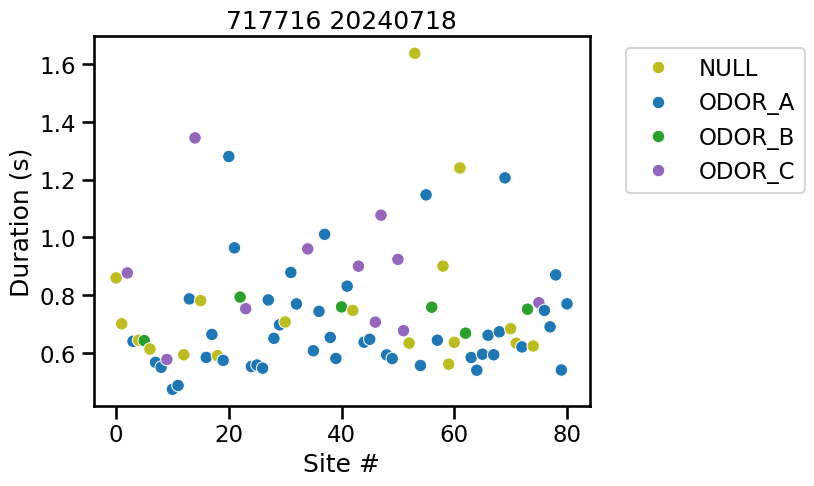

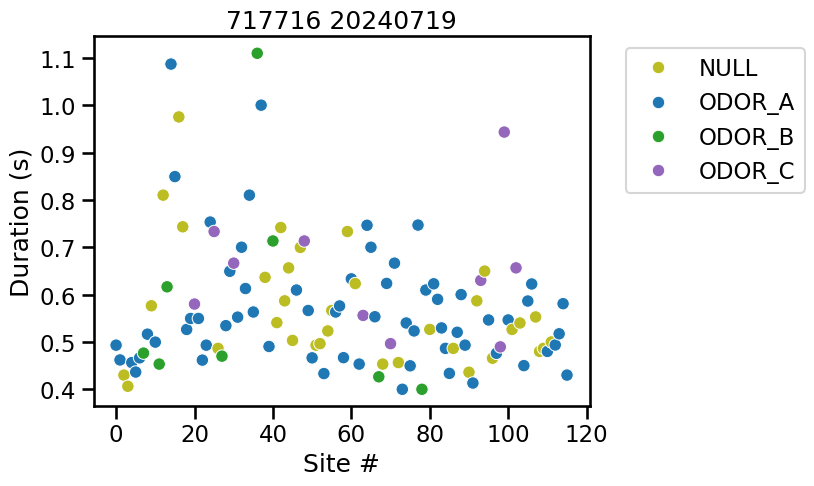

In [42]:
#combined plot
def combine_and_save_data(all_data, session_site_counts, mouse_id, save_folder):
    cumulative_site_counts = np.cumsum(session_site_counts)
    
    for i, df in enumerate(all_data):
        df['active_patch'] += np.sum(session_site_counts[:i])
    
    combined_df = pd.concat(all_data)
    
    unique_session_ids = combined_df.session_id.unique()
    combined_df['session_index'] = [np.where(unique_session_ids == session_id)[0][0] for session_id in combined_df['session_id'].values]
    combined_df['session_diff'] = list(np.diff(combined_df['session_index'].values)) + [0]
    x_locations = combined_df[combined_df['session_diff'] == 1]['active_patch'].values
    
    fig_combined, ax_combined = plt.subplots(figsize=(15, 5))
    hue_order_combined = np.sort(combined_df['odor_label'].unique())
    ax_combined = sns.scatterplot(data=combined_df, x='active_patch', y='time_spent_adjusted', hue='odor_label', hue_order=hue_order_combined, ax=ax_combined, palette=odor_list_color)
    ax_combined.set_xlabel('Cumulative Site #')
    ax_combined.set_ylabel('Duration (s)')
    ax_combined.set_title(f'Combined Sessions - {mouse_id}')
    ax_combined.legend(bbox_to_anchor=(1.05, 1), loc=2)
    
    for x_location in x_locations:
        ax_combined.vlines(x=x_location, ymin=0, ymax=5, linestyle='--', color='gray')
    
    # display the plot interactively
    plt.show()
    
    #save plot using helper function
    combined_plot_filename = f'{mouse_id}_combined.png'
    combined_plot_path = Path(save_folder) / combined_plot_filename
    save_plot_as_png(fig_combined, combined_plot_path)

    #save combined data as CSV
    filename =  str(mouse_id) + "_combined.csv"
    save_path = os.path.join(save_folder, filename)
    print (save_path)
    combined_df.to_csv(save_path)
    
    return combined_plot_path, combined_df
 


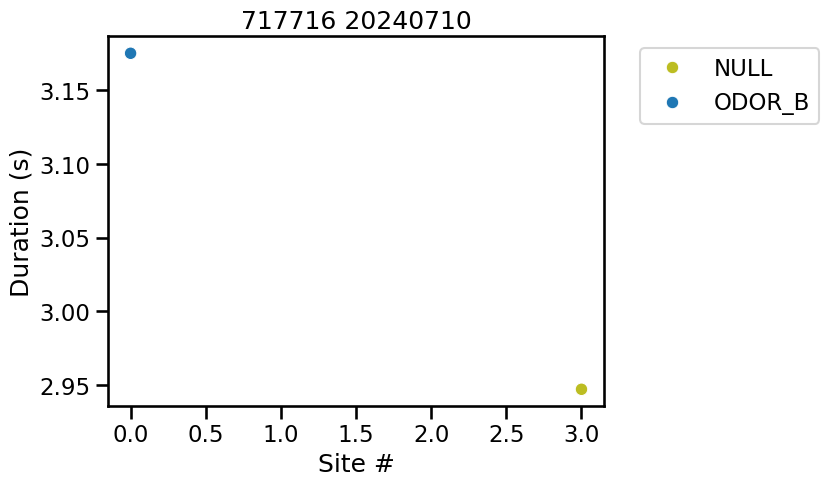

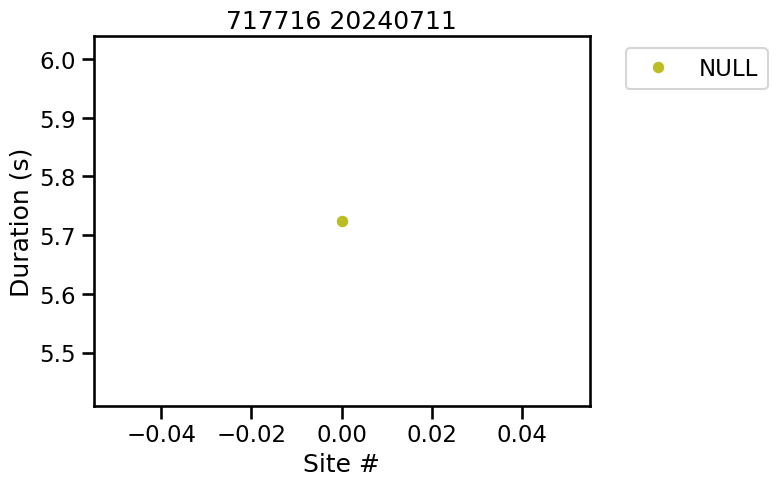

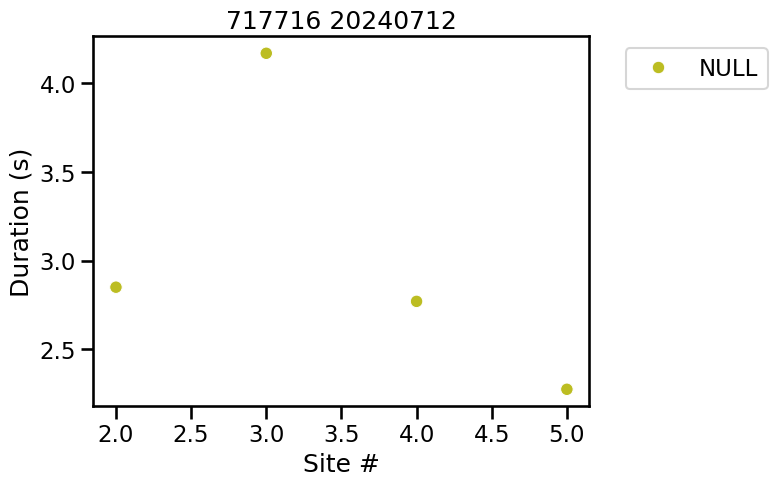

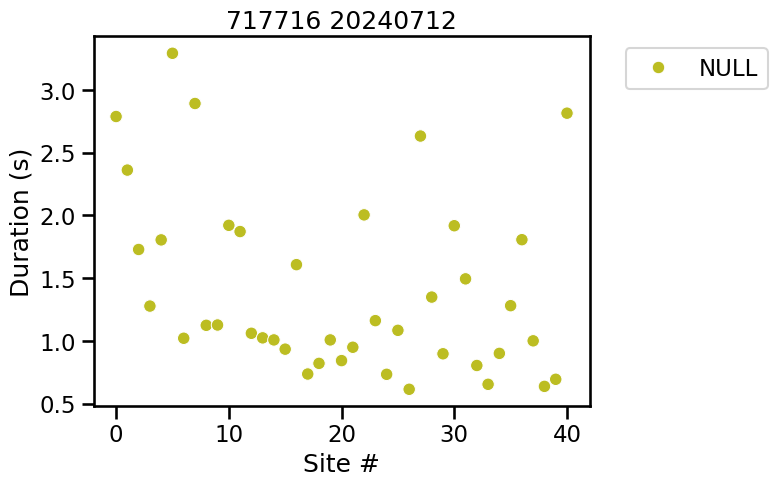

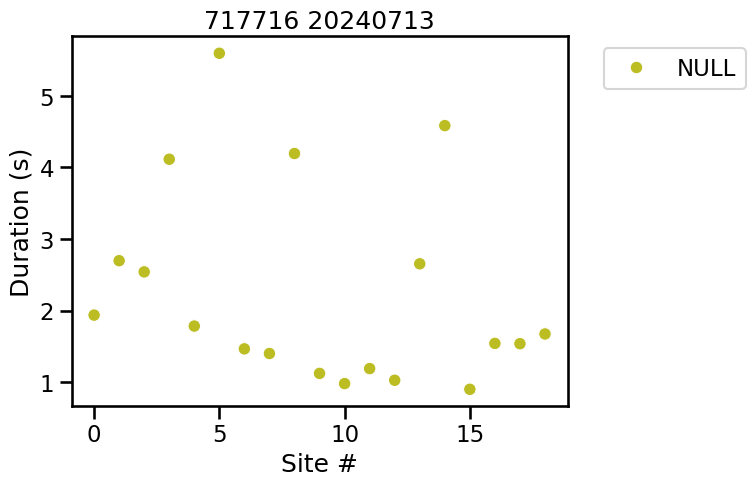

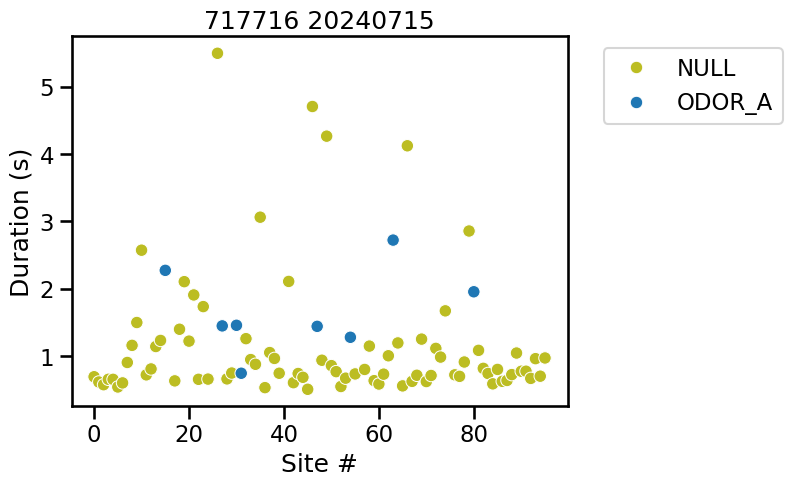

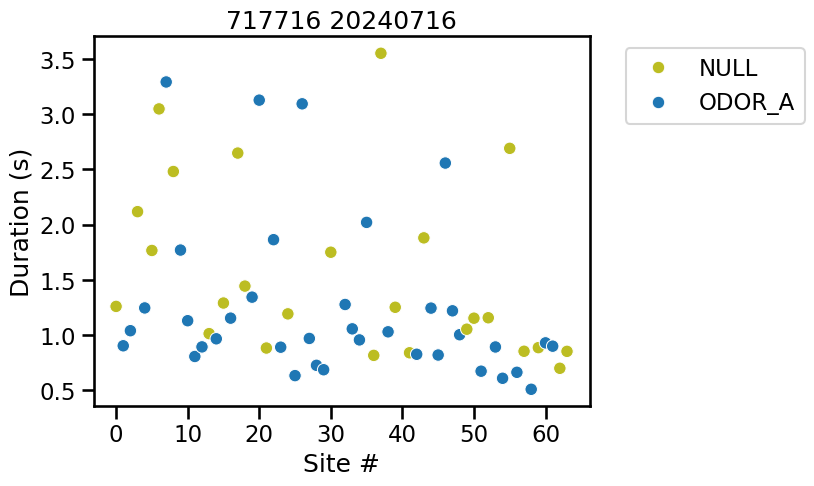

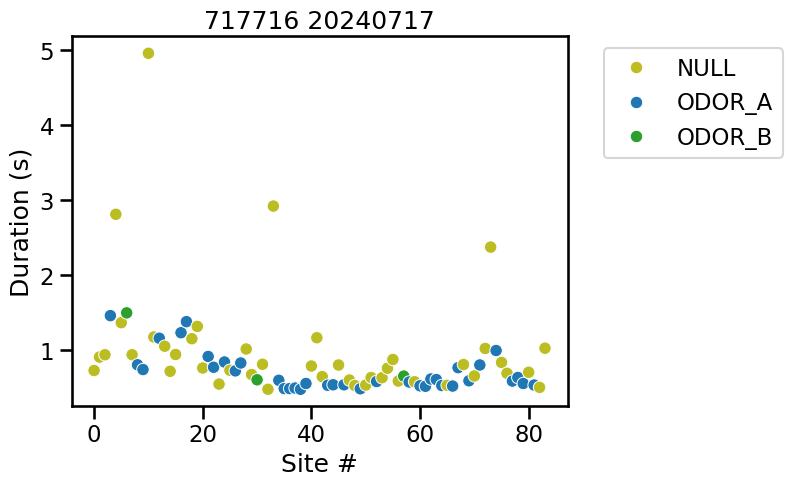

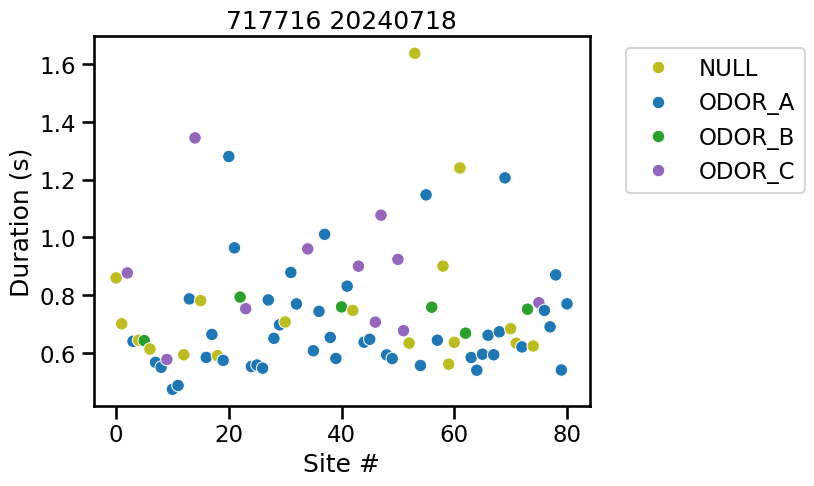

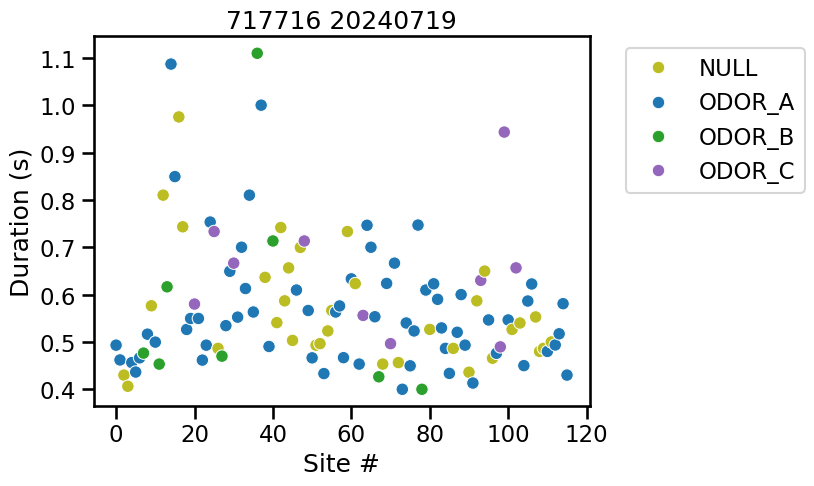

Session plots saved to: [   active_patch odor_label  time_spent_adjusted              session_id
0           0.0     ODOR_B             3.174976  717716_20240710_110945
1           3.0       NULL             2.947200  717716_20240710_110945,    active_patch odor_label  time_spent_adjusted              session_id
0           0.0       NULL             5.723597  717716_20240711_104507,    active_patch odor_label  time_spent_adjusted              session_id
0           2.0       NULL             2.849997  717716_20240712_093131
1           3.0       NULL             4.169600  717716_20240712_093131
2           4.0       NULL             2.769997  717716_20240712_093131
3           5.0       NULL             2.273997  717716_20240712_093131,     active_patch odor_label  time_spent_adjusted              session_id
0            0.0       NULL             2.786803  717716_20240712_151051
1            1.0       NULL             2.360000  717716_20240712_151051
2            2.0       NULL      

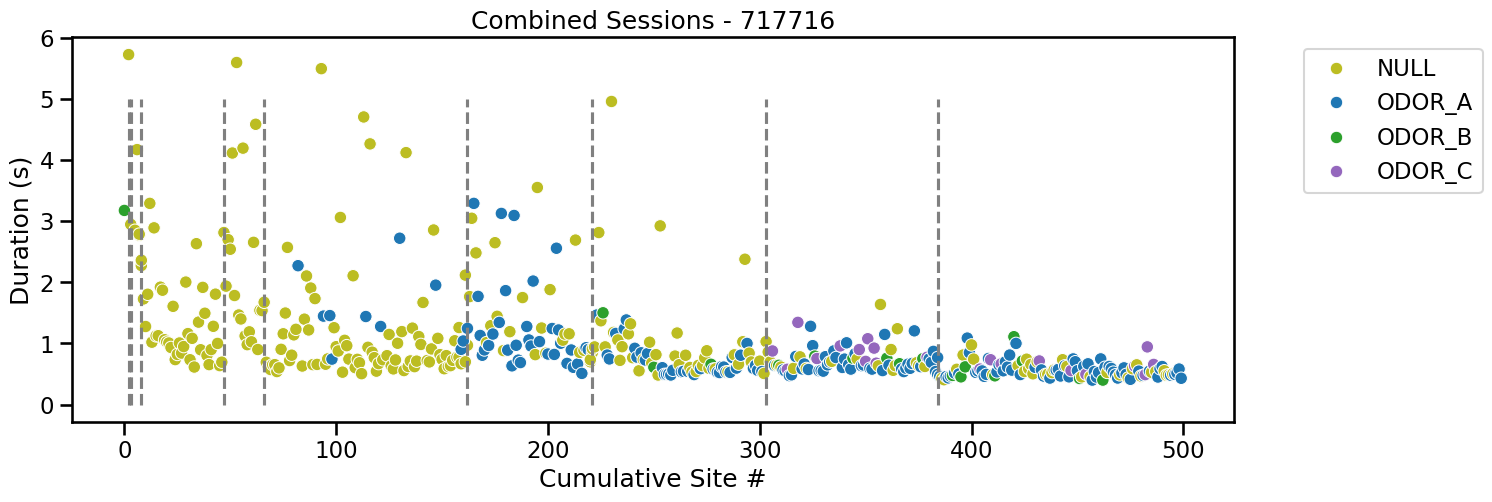

/Users/nehal.ajmal/Documents/aindproject/analysis_files/717716/717716_combined.csv
Combined plot saved to /Users/nehal.ajmal/Documents/aindproject/analysis_files/717716/717716_combined.png


In [46]:
# example usage to save plots
mouse_id = '717716'
save_folder = '/Users/nehal.ajmal/Documents/aindproject/analysis_files/' + mouse_id
all_data, session_site_counts, session_plot_paths = process_mouse_sessions(mouse_id, save_folder)
print(f"Session plots saved to: {session_plots}")

# save combined plot
combined_plot_path, combined_df = combine_and_save_data(all_data, session_site_counts, mouse_id, save_folder)
print(f"Combined plot saved to {combined_plot_path}")



In [1]:
#trial summary for one session
trial_summary = plotting.trial_collection(reward_sites[['has_choice', 'visit_number', 'odor_label', 'odor_sites']], encoder_data, mouse, session, window=(-1,3), aligned='index')